In [8]:
import sys
import os
import pickle
import json
import numpy as np
import math
from dotenv import load_dotenv
from tqdm import tqdm
from typing import List, Set, Tuple, Dict
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import precision_score, recall_score, f1_score
import math
import time

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

load_dotenv(dotenv_path=project_root)

from database_connector.qdrant_connector import connect_to_qdrant, search_points
from preprocessing.preprocessing import LSASVDPipeline, WordEmbeddingPipeline

In [9]:
# Load dada
dataset = json.load(open("./set_with_query.json", "rb"))
print(f"Length of evaluation dataset: {len(dataset)}")

eval_dataset = []
for data in dataset:
    eval_dataset.append({
        "query": data['query'],
        "label": data['film_name']
    })

# # Check some samples 
# eval_dataset[:5]

Length of evaluation dataset: 2113


In [10]:
def load_model(model_path: str):
    """Function to load embeding model from model path."""
    try:
        with open(model_path, 'rb') as f:
            embedder = pickle.load(f)
        
        return embedder
    except Exception as e:
        print(f"Got an error when loading model: {e}")
        raise

# Config model path
model_path = os.path.join(project_root, "trained_models", "tfidf.pkl")

In [11]:
def dcg_score(relevance):
    return sum(rel / math.log2(idx + 2) for idx, rel in enumerate(relevance))

def ndcg_score(relevance, k):
    dcg = dcg_score(relevance[:k])
    ideal = dcg_score(sorted(relevance, reverse=True)[:k])
    return dcg / ideal if ideal > 0 else 0.0

In [12]:
def evaluate_retrieval_system(eval_dataset, embedding_model, preprocessor, qdrant_client, collection_name, top_k=10) -> Dict[str, float]:
    """
    Evaluate the retrieval system with metrics: Precision@k, Recall@k, F1@k, MRR, MAP, nDCG@k, average query time.
    """
    precision_list, recall_list, f1_list = [], [], []
    mrr_list, ap_list, ndcg_list = [], [], []
    retrieve_time = []

    for data in tqdm(eval_dataset, desc="Evaluating..."):
        true_label = data['label']
        query = data['query']

        # Embedding
        if hasattr(preprocessor, "preprocess_single_text"):
            query = preprocessor.preprocess_single_text(query)
        elif hasattr(preprocessor, "preprocess"):
            query = preprocessor.preprocess(query)
        else:
            raise Exception("Invalid preprocessor!!!")
        
        # query_vector = embedding_model.transform(query) 
        query_vector = embedding_model.transform_doc([query]).flatten()

        # Query Qdrant
        start_time = time.time()
        search_results = search_points(
            qdrant_client=qdrant_client,
            collection_name=collection_name,
            query_vector=query_vector,
            limit=top_k
        )
        end_time = time.time()

        # Extract labels
        search_label = [
            res.payload['metadata']['film_name'] for res in search_results
        ]
        relevance_binary = [1 if label == true_label else 0 for label in search_label]

        # Precision, Recall, F1
        tp = sum(relevance_binary)
        precision = tp / top_k
        recall = 1.0 if true_label in search_label else 0.0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0

        # MRR
        rr = 0.0
        for idx, rel in enumerate(relevance_binary):
            if rel:
                rr = 1.0 / (idx + 1)
                break

        # AP
        num_relevant = 0
        precision_at_k = []
        for idx, rel in enumerate(relevance_binary):
            if rel:
                num_relevant += 1
                precision_at_k.append(num_relevant / (idx + 1))  # idx starts at 0

        if precision_at_k:
            ap = sum(precision_at_k) / len(precision_at_k)
        else:
            ap = 0.0

        # nDCG
        ndcg = ndcg_score(relevance_binary, top_k)

        # Save results
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        mrr_list.append(rr)
        ap_list.append(ap)
        ndcg_list.append(ndcg)
        retrieve_time.append(end_time - start_time)

    return {
        f'Precision@{top_k}': sum(precision_list) / len(precision_list),
        f'Recall@{top_k}': sum(recall_list) / len(recall_list),
        f'F1@{top_k}': sum(f1_list) / len(f1_list),
        'MRR': sum(mrr_list) / len(mrr_list),
        'MAP': sum(ap_list) / len(ap_list),
        f'nDCG@{top_k}': sum(ndcg_list) / len(ndcg_list),
        'Retrieve time': sum(retrieve_time) / len(retrieve_time)
    }

In [14]:
# Load preprocessor
preprocessor = LSASVDPipeline()

# Load embedding model
embedding_model = load_model(model_path)

# Connect to qdrant client 
qdrant_client = connect_to_qdrant(
    qdrant_uri=os.getenv("QDRANT_URL"),
    api_key=os.getenv("QDRANT_KEY")
)
collection_name = "tfidf"

top_k = 10
# Run evaluation
results = evaluate_retrieval_system(
    eval_dataset=eval_dataset,
    embedding_model=embedding_model,
    preprocessor=preprocessor,
    qdrant_client=qdrant_client,
    collection_name=collection_name,
    top_k=top_k
)

# Print the result
print("--- Evaluation results ---")
print(results)

Successfully connected to Qdrant!


Evaluating...: 100%|██████████| 2113/2113 [07:53<00:00,  4.46it/s]

--- Evaluation results ---
{'Precision@10': 0.07174633222905617, 'Recall@10': 0.7141504969238051, 'F1@10': 0.1303474881326305, 'MRR': 0.5617873857225493, 'MAP': 0.5614298109210558, 'nDCG@10': 0.5983138708047724, 'Retrieve time': 0.2197896112946611}


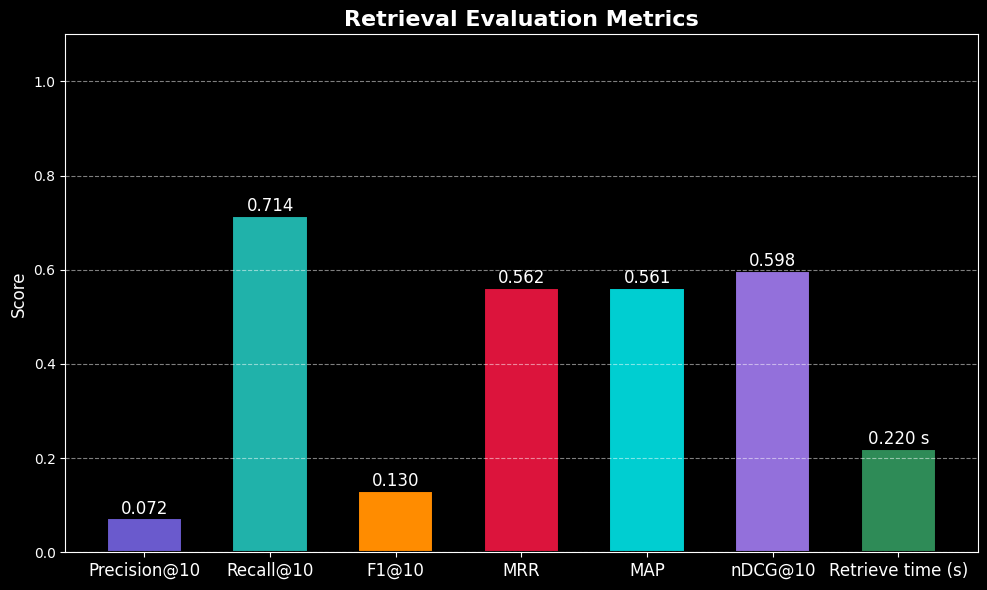

In [15]:
import matplotlib.pyplot as plt

metric_names = list(results.keys())
metric_values = list(results.values())
metric_names = [name if name != 'Retrieve time' else 'Retrieve time (s)' for name in metric_names]

colors = ['#6A5ACD', '#20B2AA', '#FF8C00', '#DC143C', '#00CED1', '#9370DB', '#2E8B57']

plt.figure(figsize=(10, 6))
bars = plt.bar(metric_names, metric_values, color=colors, width=0.6, edgecolor='black', linewidth=1.5)

for name, bar in zip(metric_names, bars):
    yval = bar.get_height()
    unit = " s" if "Retrieve" in name else ""
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}{unit}",
             ha='center', fontsize=12)

plt.title("Retrieval Evaluation Metrics", fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.1 if max(metric_values) <= 1 else max(metric_values) + 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
